In [1]:
pwd

'/home/ubuntu/kaggle/ydata-kaggle-plant-pathology/notebooks'

In [2]:
ls '../input/'

images/                         sample_submission.csv  train.csv
plant-pathology-2020-fgvc7.zip  test.csv


In [3]:
#!pip install imgaug
#!pip install nvidia-ml-py3
#!pip install -U albumentations
#!pip install --upgrade pip
#!pip install --upgrade scikit-image #fix this problem
#!pip install scikit-image==0.13.1
#!pip install numpy==1.15
!pip install -U albumentations

Requirement already up-to-date: albumentations in /home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (0.4.5)


In [4]:
import numpy as np
import pandas as pd
#import albumentations as A
#from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,random_split

import torchvision

import cv2

from sklearn.metrics import roc_auc_score as auc

import matplotlib.pyplot as plt
%matplotlib inline


INPUT_DIR = '../input/'

In [5]:
import glob
filelist = glob.glob(INPUT_DIR + 'images/*.jpg')
filelist[:5]

['../input/images/Test_452.jpg',
 '../input/images/Test_1779.jpg',
 '../input/images/Test_1308.jpg',
 '../input/images/Test_265.jpg',
 '../input/images/Test_1257.jpg']

In [6]:
df = pd.read_csv(INPUT_DIR + 'train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
df['target'] = np.argmax(df.iloc[:,1:].values, axis=1)
df.head()

,image_id,healthy,multiple_diseases,rust,scab,target
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


In [8]:
class PlantDataset(Dataset):
    def __init__(self,df,transforms=None):
        super().__init__()
        self.df = df
        self.transforms = transforms
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,idx):
        img_path = INPUT_DIR + 'images/' + self.df.loc[idx,'image_id'] + '.jpg'
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # because cv2 reads image as BGR and we want RGB
        label = np.expand_dims(self.df.target.loc[idx], axis=-1)
        label = torch.from_numpy(label.astype(np.int8))
        if not self.transforms is None:
            transformed_img = self.transforms(image=img)
            img = transformed_img['image']
        return img, label    
        
        

(1365, 2048, 3)


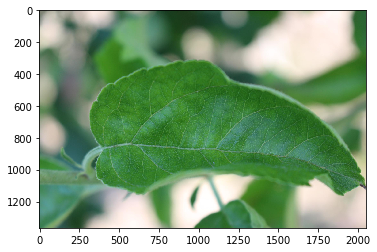

In [9]:
#train_ds = PlantDataset(df) # orig image
#train_ds = PlantDataset(df,A.Normalize()) # with transform applied
train_ds = PlantDataset(df) # no transform applied
print(train_ds[1][0].shape) # dims of a single image: (1365, 2048, 3)

plt.imshow(train_ds[2][0])

In [10]:
# To visualize the backbone (resnet) model we will use
#temp_model = torchvision.models.resnet18(pretrained=True)
#temp_model

In [11]:
class PlantModel(nn.Module):
    def __init__(self, num_classes, only_train_last_layer):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = torchvision.models.resnet18(pretrained=True)
        if only_train_last_layer:
            for param in self.backbone.parameters():
                param.requires_grad = False     
        # We can either specify the full model and then add this at the end
        # self.last = nn.Linear(in_features=self.backbone.fc.in_features, out_features=self.num_classes, bias=True)
        # Or use the quick and easy approach where we replace the last layer:
        self.backbone.fc = nn.Linear(in_features=self.backbone.fc.in_features, out_features=self.num_classes, bias=True)
        
    def forward(self, x):
        # The full approach:
        #x = self.backbone.conv1(x)
        #x = self.backbone.bn1(x)
        #... etc
        #x = self.last(x)
        # But care needs to be taken to get everything right, e.g., maybe there are some dimensions changes etc.
        #
        # Quick and easy approach:
        x = self.backbone(x)
        return x
        
        
        
        

In [12]:
#model = PlantModel(4, True)
#model

Differences between train and validation loader:
1. The data that is loaded
2. Shuffling (possibly?)
3. Augmentation transforms are applied to train but not validation. For training we would like to get slightly different image. For validation, if we do this we might get improvement that is not due to the algorithm but rather is due to the change we made to the image. Thus for validation we would not do any such stochastic augmentation. Only do transformations that are the same for all processes (??)

The criterion we will use is CrossEntropy loss which returns logits (not the softmax), thus we do not need softmax as the final layer of the model. But we do use in in computing the predictions. See below.

In [21]:

if torch.has_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu:0')

def train_single_fold(fold, tr_loader, val_loader, model, criterion, optimizer):
    training_log = [] # results for each of the epochs so that we have the log of what went on during training
    
    print('Starting training, fold: %d' % fold)

    # this can be done externally (to the function) as well
    if torch.has_cuda:
        print("Setting the model on cuda...")
        model.cuda()
        
    for epoch in range(num_epochs):        
        # training loop
        model.train()
        tr_loss = 0

        for step, batch in enumerate(tr_loader):
            imgs, labels = batch
            # appears we need to reshape this since it arrives as (batch_size x 1365,2048,3)
            # but pytorch expects the channels to be first)
            imgs = imgs.view(imgs.shape[0],3,1365,2048) 
            imgs = imgs.float()
            #imgs.to(device) 
            #imgs.to(device,dtype=torch.float)
            imgs = imgs.cuda()
            #print('Is imgs on cuda?')
            #print(imgs.is_cuda)
            labels = labels.to(device) #labels.to(device,dtype=torch.long)
            outputs = model(imgs)
            #print(outputs)
            #print(labels)
            #labels = labels.long()
            #print(labels)
            loss = criterion(outputs,torch.squeeze(labels.long())) # may need to squeeze labels; and convert to long
            loss.backward()
            tr_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            if step % 20 == 0:
                print('Finished batch: %d, training loss = %f' % (step,loss.item()))
    
        # evaluation loop
        model.eval()
        val_loss = 0
        val_preds = None
        val_labels = None
        
        for step, batch in enumerate(val_loader):
            imgs, labels = batch

            # save the labels
            if val_labels is None:
                val_labels = labels
            else:
                val_labels = torch.cat((val_labels, labels), dim=0)

            imgs = imgs.view(imgs.shape[0],3,1365,2048)  
            imgs = imgs.float()
            imgs = imgs.cuda()
            #imgs.to(device,dtype=torch.float)
            #labels.to(device,dtype=torch.long)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs,torch.squeeze(labels.long())) # may need to squeeze labels
            val_loss += loss.item()

            preds = torch.softmax(outputs,dims=1).cpu()  # to cpu because we want to have the preds as numpy; Nati wasn't sure if this was needed. 
            
            # save the preds
            if val_preds is None:
                val_preds = preds
            else:
                val_preds = torch.cat((val_preds, preds), dim=0)
                
        training_log.append({
            'epoch' : epoch,
            'train_loss' : tr_loss / len(tr_loader),
            'validation_loss' : val_loss / len(val_loader),
            'val_preds' : val_preds,
            'val_score' : auc(torch.from_numpy(pd.get_dummies(val_labels).values), val_preds, average='macro')
        })
        
        print('Epoch: %d, training loss = %f, val loss = %f' % (step, tr_loss / len(tr_loader), val_loss / len(val_loader) ))
        
            
    return val_preds, training_log
            
            

In [22]:
# create train and val loaders
# train_ds is the dataset we created with all of the data
tr_ds, val_ds = random_split(train_ds, (1400,421))
#tr_ds, val_ds = random_split(train_ds[0:61], (50,10))

tr_loader = DataLoader(tr_ds,batch_size=5,shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds,batch_size=1, num_workers=0)

In [23]:
%%time
model = PlantModel(num_classes=4, only_train_last_layer=False)

num_epochs = 5
if torch.has_cuda:
    print('Has CUDA!')
    device = torch.device('cuda:0')
    model.cuda()
else:
    device = torch.device('cpu:0')
    model.cpu()
    

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

    
train_single_fold(1, tr_loader, val_loader, model, criterion, optimizer)


Has CUDA!
Starting training, fold: 1
Setting the model on cuda...
Finished batch: 0, training loss = 1.406238
Finished batch: 20, training loss = 1.324303
Finished batch: 40, training loss = 1.959355
Finished batch: 60, training loss = 1.390373
Finished batch: 80, training loss = 1.348707
Finished batch: 100, training loss = 1.105042
Finished batch: 120, training loss = 1.270514
Finished batch: 140, training loss = 1.174487
Finished batch: 160, training loss = 1.419154


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 1365 and 2048 in dimension 1 at /opt/conda/conda-bld/pytorch_1579022034529/work/aten/src/TH/generic/THTensor.cpp:612

In [69]:
it = iter(val_loader)
#it.next()[0].view(1,3,1365,2048).shape
img, label = it.next()
img = img.float()
print(img.cuda().is_cuda)

True


In [63]:
print(torch.rand(2,3).cuda())

tensor([[0.8060, 0.3529, 0.6951],
        [0.5882, 0.5004, 0.5010]], device='cuda:0')


NameError: name 'imgs' is not defined

In [24]:
torch.__version__

'1.4.0'